In [1]:
from math import sin
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import math
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from joblib import dump, load

In [2]:
def getTrain(stock,train_ratio=0.7,validation_ratio=0.2,features=range(0,4)):
    stock.dropna()
    x=stock.iloc[:-1,features].values
    y=stock["close"].values[1:].reshape(-1,1)

    x_scalar=preprocessing.StandardScaler()
    y_scalar=preprocessing.StandardScaler()

    train_ends=math.floor(x.shape[0]*train_ratio)
    validation_ends=train_ends+1+math.floor(x.shape[0]*validation_ratio)

    x_train=x_scalar.fit_transform(x[0:train_ends,:])
    y_train=y_scalar.fit_transform(y[0:train_ends]).reshape(-1)

    x_validation=x_scalar.transform(x[train_ends:validation_ends,:])
    y_validation=y_scalar.transform(y[train_ends:validation_ends]).reshape(-1)

    x_test=x_scalar.transform(x[validation_ends:,:])
    y_test=y_scalar.transform(y[validation_ends:]).reshape(-1)
    return x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar

In [3]:
def slice_time_series(x,y,win_size):
    x_sliced=[]
    y_sliced=[]
    for t in range(len(x)-win_size):
        x_sliced.append(x[t:t+win_size])
        y_sliced.append(y[t+win_size-1])
    x_sliced=np.array(x_sliced)
    y_sliced=np.array(y_sliced)
    return x_sliced.reshape((-1,win_size,feature_size)),y_sliced

In [4]:
def build_model(win_size,feature_size,hiden=20):
    i=Input(shape=(win_size,feature_size))
    x=LSTM(hiden)(i)
    x=Dense(1)(x)
    model=Model(i,x)
    model.compile(loss='mse',optimizer=Adam(lr=0.01))
    return model

In [5]:
def multi_step_predict(model,data,N=1,feature_size=1):
    y_hat=[]
    x_test_last=data
    for i in range(N):
        y_hat_s1=model.predict(x_test_last.reshape(1,-1,feature_size))[0,0]
        x_test_last=np.roll(x_test_last,-1)
        x_test_last[-1]=y_hat_s1
        y_hat.append(y_hat_s1)
    return y_hat


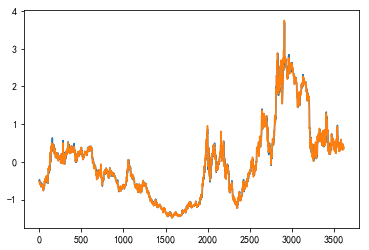

In [6]:
stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600218", adjust="hfq")  # 利用 AkShare 获取后复权数据

x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar=getTrain(
    stock_hfq_df,train_ratio=0.7,validation_ratio=0.2,features=range(0,4))

plt.plot(x_train[:,0])
plt.plot(y_train[:])

In [7]:
win_size=50
feature_size=x_train.shape[1]
x_train,y_train=slice_time_series(x_train,y_train,win_size)
x_validation,y_validation=slice_time_series(x_validation,y_validation,win_size)
x_test,y_test=slice_time_series(x_test,y_test,win_size)

In [8]:
model=build_model(win_size,feature_size,hiden=30)

In [9]:
result=model.fit(x_train,y_train,
    batch_size=100,
    epochs=30,
    validation_data=(x_validation,y_validation))

Epoch 1/30
36/36 [==============================] - 1s 25ms/step - loss: 0.0460 - val_loss: 0.0206
Epoch 2/30
36/36 [==============================] - 1s 14ms/step - loss: 0.0080 - val_loss: 0.0159
Epoch 3/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 4/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0153
Epoch 5/30
36/36 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0137
Epoch 6/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0061 - val_loss: 0.0135
Epoch 7/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.0131
Epoch 8/30
36/36 [==============================] - 1s 14ms/step - loss: 0.0053 - val_loss: 0.0111
Epoch 9/30
36/36 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 10/30
36/36 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 11/

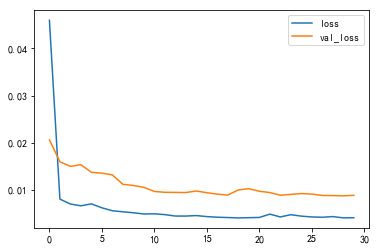

In [10]:
plt.plot(result.history['loss'],label="loss")
plt.plot(result.history['val_loss'],label="val_loss")
plt.legend()

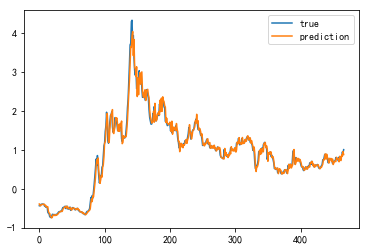

In [11]:
y_hat=model.predict(x_test)
plt.plot(y_test,label='true')
plt.plot(y_hat,label='prediction')

plt.legend()

In [12]:
mase=np.sum(np.abs(y_hat[1:].reshape(-1)-y_test[1:]))/np.sum(np.abs(y_test[:-1]-y_test[1:]))
print(mase)

1.0586017637045284


In [13]:
true_up=((y_test[1:]-y_test[:-1])>0)
pred_up=((y_hat[:-1,0]-y_test[:-1])>0)
correct=(true_up==pred_up)
acc=np.sum(true_up==pred_up)/len(true_up)
print(acc)

0.5278969957081545


In [14]:
model.save('stock_model.mod')
dump(x_scalar, 'x_scaler.bin', compress=True)
dump(y_scalar, 'y_scaler.bin', compress=True)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: stock_model.mod\assets


['y_scaler.bin']